#1. GBDT (xgboost/lightgbm)

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Loading Libraries

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy import sparse
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

### Loading Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "drive/My Drive/Colab Notebooks"

In [ ]:
import pandas as pd
data = pd.read_csv(path+"/preprocessed_data.csv")
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


## Sentiment Scores of Preprocessed Essay

In [ ]:
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid    = SentimentIntensityAnalyzer()
negative = []
positive = []
neutral = []
compound = []
def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
100%|██████████| 109248/109248 [03:39<00:00, 497.10it/s]


In [ ]:
data['negative'] = negative
data['positive'] = positive
data['neutral'] = neutral
data['compound'] = compound

data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,negative,positive,neutral,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897


In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative,positive,neutral,compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y) 

In [ ]:
X_train.shape

(73196, 12)

##Encoding Categorical Features: Essay

### using tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit(X_train['essay'].values)
X_train_tfidf_es = vectorizer.transform(X_train['essay'].values)
X_test_tfidf_es = vectorizer.transform(X_test['essay'].values)

In [ ]:
glove_vector_path = 'drive/My Drive/Colab Notebooks/gllove_vectors'

In [ ]:
import pickle
with open(glove_vector_path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Hence we are now converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())     
 
# Function to generate Word2Vec referencing "4_Reference_Vectorization.ipynb" given in the instruction
def generate_w2v_from_text(essays_text_arr):
  # compute average word2vec for each review.
    tfidf_w2v_vectors = []
    # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(essays_text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0
        # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (sentence.count(word) / len(sentence.split()))  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
        #tfidf_w2v_ve = sparse.csr_matrix(tfidf_w2v_vectors)
    return tfidf_w2v_vectors

X_train_vectorized_tfidf_w2v_essay = sparse.csr_matrix(generate_w2v_from_text(X_train['essay'].values))
X_test_vectorized_tfidf_w2v_essay = sparse.csr_matrix(generate_w2v_from_text(X_test['essay'].values))

100%|██████████| 36052/36052 [01:24<00:00, 427.71it/s]


## Encoding Categorical Features: Project Title

### using tfidf

### Response Encoding

In [ ]:
# Defining fit function 
def fit(feature):
    # storing 'project_is_approved' column to x_train
    X_train['class_label'] = y_train 
    # getting value counts(denominator) of each category
    cnt = X_train[ feature ].value_counts() 
    feature_dict = dict()    #Creating Empty dict
    for i, denom in cnt.items():
        vector = []
        for j in range(2):
            compare =X_train.loc[ ( X_train['class_label'] == j ) & (X_train[feature] == i ) ]
            vector.append( len(compare) / denom)
        # adding probability of each class label for a pariticular category of feature    
        feature_dict[i] = vector    
    return feature_dict  
# Defining Transform Function
def transform(feature, df ):
    feature_dict = fit(feature)
    cnt = X_train[feature].value_counts()
    f=[]
    for ct in df[feature]:
        if ct in dict( cnt ).keys():   # transform test data with trainning probabilities
            f.append( feature_dict[ct] )
        else:
            f.append([0.5, 0.05])
    return f

##Encoding Categorical Features: Teacher Prefix




In [ ]:
X_train_teacher_res =np.array(transform('teacher_prefix',X_train))
X_test_teacher_res = np.array(transform('teacher_prefix',X_test))

print("After vectorizations")
print(X_train_teacher_res.shape, y_train.shape)
print(X_test_teacher_res.shape, y_test.shape)

print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)
After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


##Encoding Categorical Features: Project Grade

In [ ]:
X_train_project_res =np.array(transform('project_grade_category',X_train))
X_test_project_res = np.array(transform('project_grade_category',X_test))

print("After vectorizations")
print(X_train_project_res.shape, y_train.shape)
print(X_test_project_res.shape, y_test.shape)

print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


##Encoding Categorical Features: School State

In [ ]:
X_train_state_res =np.array(transform('school_state',X_train))
X_test_state_res =np.array(transform('school_state',X_test)) 
print("After vectorizations")
print(X_train_state_res.shape, y_train.shape)
print(X_test_state_res.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


##Encoding Categorical Features: Clean Categories

In [ ]:
X_train_category_res =np.array(transform('clean_categories',X_train))
X_test_category_res = np.array(transform('clean_categories',X_test))

print("After vectorizations")
print(X_train_category_res.shape, y_train.shape)
print(X_test_category_res.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


##Encoding Categorical Features: Clean Sub Categories

In [ ]:
X_train_subcategory_res = np.array(transform('clean_subcategories',X_train))
X_test_subcategory_res = np.array(transform('clean_subcategories',X_test))
print("After vectorizations")
print(X_train_subcategory_res.shape, y_train.shape)
print(X_test_subcategory_res.shape, y_test.shape)
print("="*100)
     

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


##Encoding Numerical Features: Price

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


##Encoding Numerical Features: Previous Project

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previous_project_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_project_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_previous_project_norm.shape, y_train.shape)
print(X_test_previous_project_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Negative

In [ ]:
sentiments_standardizer = StandardScaler()

# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['negative'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_negative_sent_standardized = sentiments_standardizer.transform(X_train['negative'].values.reshape(-1,1))
X_test_negative_sent_standardized = sentiments_standardizer.transform(X_test['negative'].values.reshape(-1,1))

print('After Standardizing on negative column checking the shapes ')
print(X_train_negative_sent_standardized.shape, y_train.shape)
print(X_test_negative_sent_standardized.shape, y_test.shape)

After Standardizing on negative column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Positive

In [ ]:
sentiments_standardizer.fit(X_train['positive'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_positive_sent_standardized = sentiments_standardizer.transform(X_train['positive'].values.reshape(-1,1))
X_test_positive_sent_standardized = sentiments_standardizer.transform(X_test['positive'].values.reshape(-1,1))

print('After Standardizing on positive column checking the shapes ')
print(X_train_positive_sent_standardized.shape, y_train.shape)
print(X_test_positive_sent_standardized.shape, y_test.shape)

After Standardizing on positive column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Neutral

In [ ]:
sentiments_standardizer.fit(X_train['neutral'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_neutral_sent_standardized = sentiments_standardizer.transform(X_train['neutral'].values.reshape(-1,1))
X_test_neutral_sent_standardized = sentiments_standardizer.transform(X_test['neutral'].values.reshape(-1,1))

print('After Standardizing on neutral column checking the shapes ')
print(X_train_neutral_sent_standardized.shape, y_train.shape)
print(X_test_neutral_sent_standardized.shape, y_test.shape)

After Standardizing on neutral column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


##Sentiment Scores : Compound

In [ ]:
sentiments_standardizer.fit(X_train['compound'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_compound_sent_standardized = sentiments_standardizer.transform(X_train['compound'].values.reshape(-1,1))
X_test_compound_sent_standardized = sentiments_standardizer.transform(X_test['compound'].values.reshape(-1,1))

print('After Standardizing on compound column checking the shapes ')
print(X_train_compound_sent_standardized.shape, y_train.shape)
print(X_test_compound_sent_standardized.shape, y_test.shape)

After Standardizing on compound column checking the shapes 
(73196, 1) (73196,)
(36052, 1) (36052,)


### Merging All Features of Set 1

In [ ]:
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_tfidf_es, X_train_state_res, X_train_teacher_res, X_train_project_res, X_train_price_norm,X_train_category_res,X_train_subcategory_res,X_train_previous_project_norm,X_train_negative_sent_standardized ,X_train_positive_sent_standardized,X_train_neutral_sent_standardized,X_train_compound_sent_standardized)).tocsr()
X_te_set_one = hstack((X_test_tfidf_es, X_test_state_res, X_test_teacher_res, X_test_project_res, X_test_price_norm,X_test_category_res,X_test_subcategory_res,X_test_previous_project_norm,X_test_negative_sent_standardized ,X_test_positive_sent_standardized,X_test_neutral_sent_standardized,X_test_compound_sent_standardized)).tocsr()

In [ ]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 14251)
(36052, 14251)


## Applying GBDT on SET 1 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"learning_rate" : [0.1,0.3,0.5,0.7],"n_estimators":[15,20,40,60] }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                         'n_estimators': [15, 20, 40, 60]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
clf.best_params_

{'learning_rate': 0.3, 'n_estimators': 60}

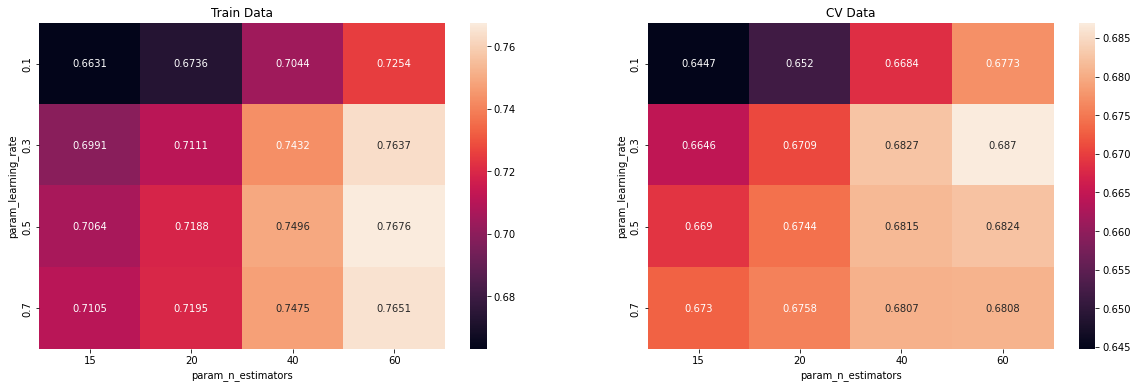

In [ ]:
results_from_gridsearchcv = pd.DataFrame(clf.cv_results_).groupby(['param_learning_rate', 'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]

max_auc_scores = results_from_gridsearchcv

max_auc_scores = max_auc_scores

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(max_auc_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_auc_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Data')
ax[1].set_title('CV Data')
plt.show()

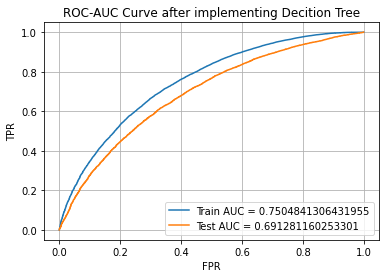

In [ ]:
dt_clf= GradientBoostingClassifier(learning_rate = clf.best_params_["learning_rate"], n_estimators= clf.best_params_["n_estimators"])
dt_clf.fit(X_tr_set_one, y_train )

y_train_predicted = dt_clf.predict_proba(X_tr_set_one)[:,1]
y_test_predicted = dt_clf.predict_proba(X_te_set_one)[:,1]

s1_train_fpr, s1_train_tpr, s1_train_threshold = roc_curve(y_train, y_train_predicted)
s1_test_fpr, s1_test_tpr, s1_test_threshold = roc_curve(y_test, y_test_predicted)

plt.plot(s1_train_fpr, s1_train_tpr, label="Train AUC = "+str(auc(s1_train_fpr, s1_train_tpr)))
plt.plot(s1_test_fpr, s1_test_tpr, label="Test AUC = "+str(auc(s1_test_fpr, s1_test_tpr)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC-AUC Curve after implementing Decition Tree')
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.46762666766825717 for threshold 0.848
the maximum value of tpr*(1-fpr) 0.4115937118322937 for threshold 0.858
CONFUSION MATRIX OF TRAIN DATA




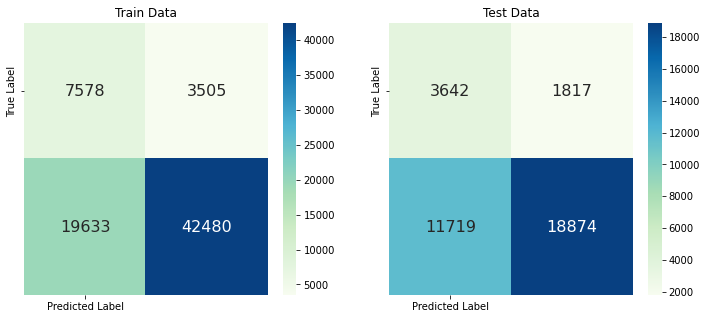

In [ ]:
#Train Data  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
best_tr = find_best_threshold(s1_train_threshold, s1_train_fpr, s1_train_tpr)
best_te = find_best_threshold(s1_test_threshold, s1_test_fpr, s1_test_tpr)

cm_tr = metrics.confusion_matrix(y_train,predict_with_best_t(y_train_predicted, best_tr))  
cm_te = metrics.confusion_matrix(y_test,predict_with_best_t(y_test_predicted, best_te))

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
fig,ax = plt.subplots(1,2, figsize=(12,5)) 

sns.heatmap(cm_tr, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[0])
sns.heatmap(cm_te, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')

plt.show()

# Set 2


### Encoding Essay using tfidf w2v

### Encoding Project Title using tfidf w2v

In [ ]:
from scipy.sparse import hstack
X_tr_set_two = hstack((X_train_vectorized_tfidf_w2v_essay, X_train_state_res, X_train_teacher_res, X_train_project_res, X_train_price_norm,X_train_category_res,X_train_subcategory_res,X_train_previous_project_norm,X_train_negative_sent_standardized ,X_train_positive_sent_standardized,X_train_neutral_sent_standardized,X_train_compound_sent_standardized)).tocsr()
X_te_set_two = hstack((X_test_vectorized_tfidf_w2v_essay, X_test_state_res, X_test_teacher_res, X_test_project_res, X_test_price_norm,X_test_category_res,X_test_subcategory_res,X_test_previous_project_norm,X_test_negative_sent_standardized ,X_test_positive_sent_standardized,X_test_neutral_sent_standardized,X_test_compound_sent_standardized)).tocsr()

### Applying GBDT on Set 2

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"learning_rate" : [0.1,0.3,0.5,0.7],"n_estimators":[15,20,40] }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_two,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                         'n_estimators': [15, 20, 40]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
clf.best_params_

{'learning_rate': 0.3, 'n_estimators': 40}

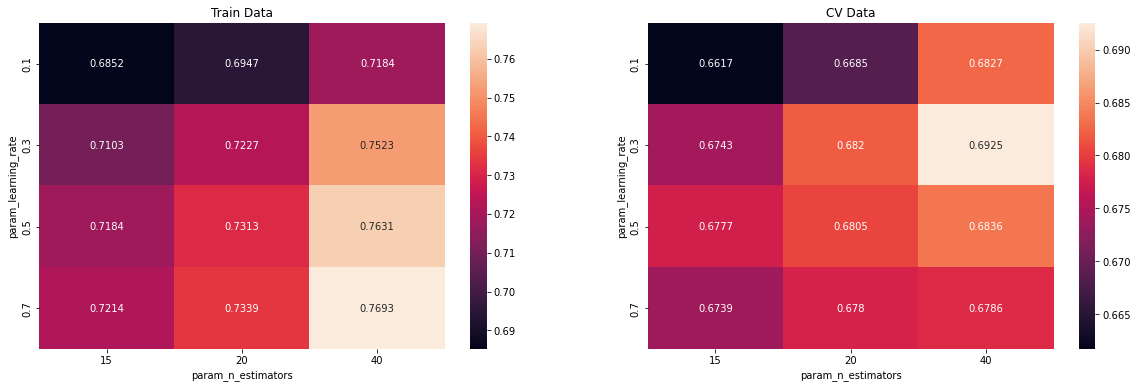

In [ ]:
results_from_gridsearchcv = pd.DataFrame(clf.cv_results_)

max_auc_scores = results_from_gridsearchcv.groupby(['param_learning_rate', 'param_n_estimators']).max()

max_auc_scores = max_auc_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(max_auc_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_auc_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Data')
ax[1].set_title('CV Data')
plt.show()

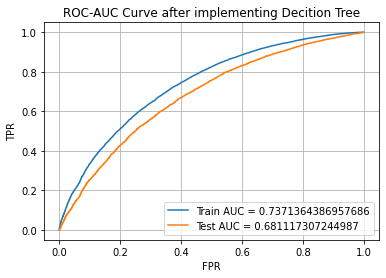

In [ ]:
dt_clf = GradientBoostingClassifier(learning_rate = clf.best_params_["learning_rate"], n_estimators= clf.best_params_["n_estimators"])
dt_clf.fit(X_tr_set_two, y_train)

y_train_predicted = dt_clf.predict_proba(X_tr_set_two)[:,1]
y_test_predicted = dt_clf.predict_proba(X_te_set_two)[:,1]

s2_train_fpr, s2_train_tpr, s2_train_threshold = roc_curve(y_train, y_train_predicted)
s2_test_fpr, s2_test_tpr, s2_test_threshold = roc_curve(y_test, y_test_predicted)

plt.plot(s2_train_fpr, s2_train_tpr, label="Train AUC = "+str(auc(s2_train_fpr, s2_train_tpr)))
plt.plot(s2_test_fpr, s2_test_tpr, label="Test AUC = "+str(auc(s2_test_fpr, s2_test_tpr)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC-AUC Curve after implementing Decition Tree')
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.45360217502778283 for threshold 0.847
the maximum value of tpr*(1-fpr) 0.4033282591604875 for threshold 0.845
CONFUSION MATRIX OF TRAIN DATA




Text(0.5, 1.0, 'Test Data')

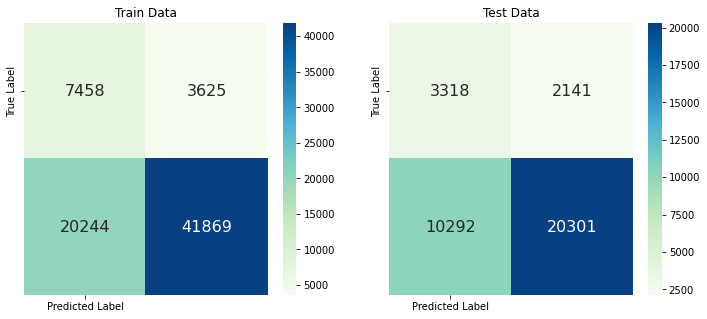

In [ ]:
best_tr = find_best_threshold(s2_train_threshold , s2_train_fpr, s2_train_tpr)
best_te = find_best_threshold(s2_test_threshold, s2_test_fpr, s2_test_tpr)
cm_tr = metrics.confusion_matrix(y_train,predict_with_best_t(y_train_predicted, best_tr))  
cm_te = metrics.confusion_matrix(y_test,predict_with_best_t(y_test_predicted, best_te))
fig,ax = plt.subplots(1,2, figsize=(12,5)) 
print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")

sns.heatmap(cm_tr, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[0])
sns.heatmap(cm_te, xticklabels=['Predicted Label'], yticklabels=['True Label'], annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16},ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')

### SUMMARY

In [ ]:

from prettytable import PrettyTable
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Train-AUC", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row([1,"TFIDF", "GRADIENT BOOSTING CLASSIFIER", "learning rate =0.3 , n_estimators=60", 0.75048, 0.69128])
table.add_row([2,"TFIDF W2V", "GRADIENT BOOSTING CLASSIFIER"," learning rate =0.3 , n_estimators=40", 0.73713, 0.68111])
print(table)
     

+-------+------------+------------------------------+---------------------------------------+-----------+----------+
| Sl.N0 | Vectorizer |            Model             |            Hyper Parameter            | Train-AUC | Test-AUC |
+-------+------------+------------------------------+---------------------------------------+-----------+----------+
|   1   |   TFIDF    | GRADIENT BOOSTING CLASSIFIER |  learning rate =0.3 , n_estimators=60 |  0.75048  | 0.69128  |
+-------+------------+------------------------------+---------------------------------------+-----------+----------+
|   2   | TFIDF W2V  | GRADIENT BOOSTING CLASSIFIER |  learning rate =0.3 , n_estimators=40 |  0.73713  | 0.68111  |
+-------+------------+------------------------------+---------------------------------------+-----------+----------+
